In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import Flowers102
from torchvision import transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
# Workout actual mean and std of the dataset
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = Flowers102(root='', split='train', transform=transform, download=True)

# R, G, B
channel_sum = torch.zeros(3)
channel_sum_squared = torch.zeros(3)
count = 0

for img, _ in train_dataset:
    channel_sum += torch.mean(img, dim=(1, 2))
    channel_sum_squared += torch.mean(img ** 2, dim=(1, 2))
    count += 1

mean = (channel_sum / count).numpy()
std = (torch.sqrt(channel_sum_squared / count - mean ** 2)).numpy()

print("Mean:", mean)
print("Std:", std)

Mean: [0.4329607  0.38192013 0.29637718]
Std: [0.29519516 0.24728866 0.2741795 ]


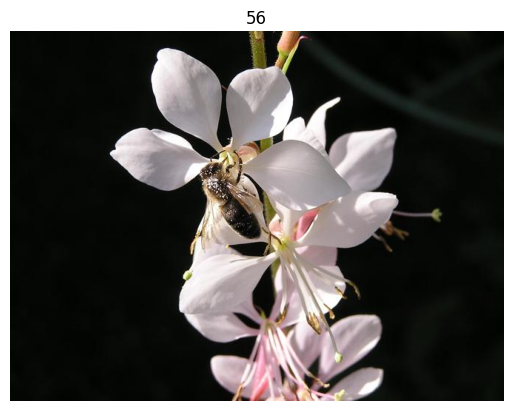

(500, 667, 3)


In [3]:
img, label = train_dataset[567]
np_img = img.permute(1, 2, 0).numpy()
plt.title(label)
plt.imshow((np_img * 255).astype('uint8'))
plt.axis('off')
plt.show()
print(np_img.shape)

In [4]:
train_transform = transforms.Compose([
		transforms.CenterCrop((500,500)),
		transforms.Resize(size=(224,224)),
		transforms.ColorJitter(brightness=0.2,contrast=0.4,hue=0.1),
		transforms.RandomRotation(90),
		transforms.RandomHorizontalFlip(),
		transforms.RandomVerticalFlip(),
		transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
		transforms.ToTensor(),
		transforms.Normalize(mean=mean, std=std),
])

transform = transforms.Compose([
		transforms.Resize((224,224)),
		transforms.ToTensor(),
		transforms.Normalize(mean=mean, std=std),
])

In [5]:
training_data = Flowers102( root='', split='train', transform=train_transform, download=False)
testing_data = Flowers102(root='',split='test',transform=transform,download=False)
evaluation_data = Flowers102(root='',split='val',transform=transform,download=False)

In [6]:
print('Training data has {} instances'.format(len(training_data)))
print('Evaluation data has {} instances'.format(len(evaluation_data)))
print('Testing data has {} instances'.format(len(testing_data)))

Training data has 1020 instances
Evaluation data has 1020 instances
Testing data has 6149 instances


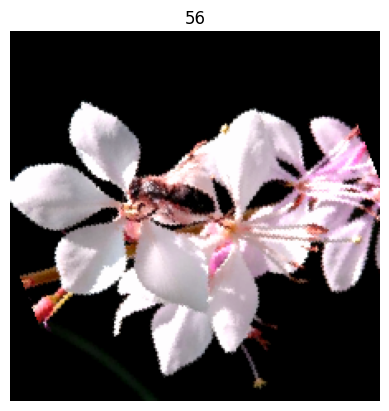

In [7]:
img, label = training_data[567] # just a random instance to see how the data has been normalised
img = (img.squeeze().permute(1, 2, 0).numpy() * std + mean.clip(0, 1))
plt.title(label)
plt.imshow((img * 255).astype('uint8'))
plt.axis('off')
plt.show()

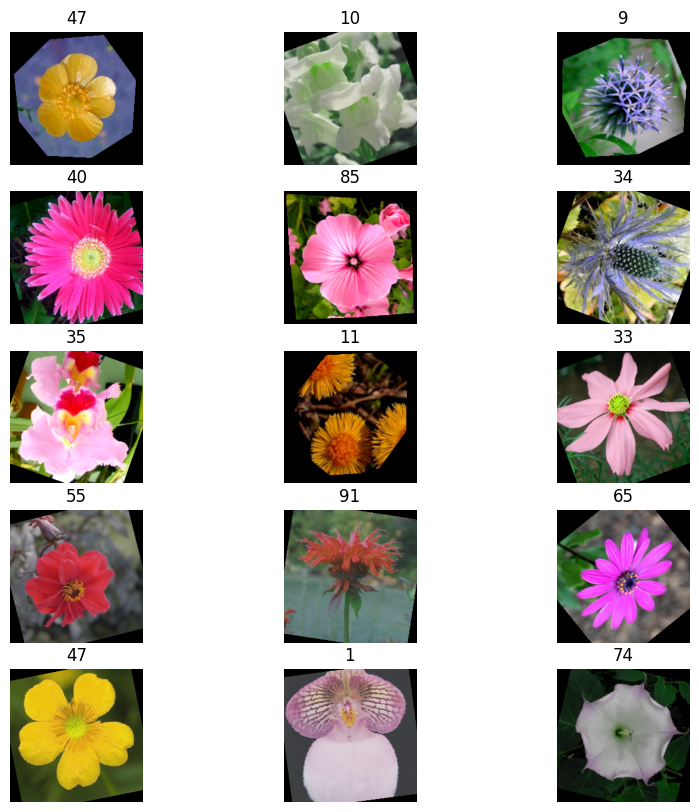

In [8]:
figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 5
for i in range(1, cols * rows + 1):
	sample_idx = torch.randint(len(training_data), size=(1,)).item()
	img, label = training_data[sample_idx]
	img = (img.squeeze().permute(1, 2, 0).numpy() * std + mean.clip(0, 1))
	figure.add_subplot(rows, cols, i)
	plt.title(label)
	plt.imshow((img * 255).astype('uint8'))
	plt.axis('off')
plt.show()

In [9]:
# transform simple NN into a CNN
class FlowerClassifier(nn.Module):
	def __init__(self):
			super(FlowerClassifier, self).__init__()
			self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
			self.bn1 = nn.BatchNorm2d(32)

			self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
			self.bn2 = nn.BatchNorm2d(64)

			self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
			self.bn3 = nn.BatchNorm2d(128)

			self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
			self.bn4 = nn.BatchNorm2d(256)

			self.conv5 = nn.Conv2d(256, 512, kernel_size=3)
			self.bn5 = nn.BatchNorm2d(512)

			self.conv6 = nn.Conv2d(512, 256, kernel_size=3)
			self.bn6 = nn.BatchNorm2d(256)

			self.pool = nn.MaxPool2d(2, 2)
			self.dropout = nn.Dropout(p=0.025)
			self.flatten = nn.Flatten()
			self.fc = nn.Linear(256, 102)

	def forward(self, x):
			x = self.pool(F.relu(self.bn1(self.conv1(x))))
			x = self.dropout(x)

			x = self.pool(F.relu(self.bn2(self.conv2(x))))
			x = self.dropout(x)

			x = self.pool(F.relu(self.bn3(self.conv3(x))))
			x = self.dropout(x)

			x = self.pool(F.relu(self.bn4(self.conv4(x))))
			x = self.dropout(x)

			x = self.pool(F.relu(self.bn5(self.conv5(x))))
			x = self.dropout(x)

			x = self.pool(F.relu(self.bn6(self.conv6(x))))
			x = self.flatten(x)
			x = self.fc(x)

			return x

In [10]:
# Check if CUDA is available
if torch.cuda.is_available():
	print("CUDA is available!")
	device = torch.device("cuda")
else:
	print("CUDA is not available. The model will use CPU.")
	device = torch.device("cpu")

CUDA is available!


In [11]:
def plot_graphs(train_losses, eval_losses, eval_accuracies):
    # Plotting the training and evaluation losses
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(eval_losses) + 1), eval_losses, label='Evaluation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Evaluation Losses')
    plt.legend()
    plt.show()

    # Plotting the evaluation accuracy
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, len(eval_accuracies) + 1), eval_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.show()

In [12]:
def train(model, training_loader, evaluation_loader, criterion, optimizer, patience=5, epochs=10):
	train_losses = []
	eval_losses = []
	eval_accuracies = []

	best_valid_loss = np.inf
	patience_counter = 0

	for epoch in range(epochs):
		model.train()
		training_loss = 0.0
		for inputs, labels in training_loader:
			inputs, labels = inputs.to(device), labels.to(device)
			optimizer.zero_grad()
			outputs = model(inputs)
			loss = criterion(outputs, labels)
			loss.backward()
			optimizer.step()
			training_loss += loss.item() * inputs.size(0)

		training_loss /= len(training_loader.dataset)
		train_losses.append(training_loss)

		model.eval()
		evaluation_loss = 0.0
		correct = 0
		total = 0
		with torch.no_grad():
			for inputs, labels in evaluation_loader:
				inputs, labels = inputs.to(device), labels.to(device)
				outputs = model(inputs)
				loss = criterion(outputs, labels)
				evaluation_loss += loss.item() * inputs.size(0)
				_, predicted = torch.max(outputs, 1)
				total += labels.size(0)
				correct += (predicted == labels).sum().item()

		evaluation_loss /= len(evaluation_loader.dataset)
		evaluation_accuracy = correct / total
		eval_losses.append(evaluation_loss)
		eval_accuracies.append(evaluation_accuracy)

		print(
			f'Epoch {epoch + 1}/{epochs}, Training Loss: {training_loss:.4f}, Evaluation Loss: {evaluation_loss:.4f}, Val Accuracy: {evaluation_accuracy:.4f}')

		if evaluation_loss < best_valid_loss:
				best_valid_loss = evaluation_loss
				patience_counter = 0
		else:
				patience_counter += 1
				if patience_counter >= patience:
						print(f'Validation loss did not improve for {patience} epochs. Early stopping...')
						break

	print('Training finished.')
	plot_graphs(train_losses, eval_losses, eval_accuracies)

In [13]:
training_loader = DataLoader(training_data, batch_size=64, shuffle=True)
evaluation_loader = DataLoader(evaluation_data, batch_size=64, shuffle=False)

Epoch 1/200, Training Loss: 4.5511, Evaluation Loss: 4.6106, Val Accuracy: 0.0265
Epoch 2/200, Training Loss: 4.2365, Evaluation Loss: 4.3376, Val Accuracy: 0.0510
Epoch 3/200, Training Loss: 4.0313, Evaluation Loss: 4.0647, Val Accuracy: 0.1059
Epoch 4/200, Training Loss: 3.9341, Evaluation Loss: 3.9103, Val Accuracy: 0.1392
Epoch 5/200, Training Loss: 3.7988, Evaluation Loss: 3.7976, Val Accuracy: 0.1755
Epoch 6/200, Training Loss: 3.7016, Evaluation Loss: 3.6745, Val Accuracy: 0.2069
Epoch 7/200, Training Loss: 3.5696, Evaluation Loss: 3.6126, Val Accuracy: 0.2245
Epoch 8/200, Training Loss: 3.4677, Evaluation Loss: 3.5037, Val Accuracy: 0.2235
Epoch 9/200, Training Loss: 3.3796, Evaluation Loss: 3.4776, Val Accuracy: 0.2402
Epoch 10/200, Training Loss: 3.3019, Evaluation Loss: 3.3736, Val Accuracy: 0.2686
Epoch 11/200, Training Loss: 3.1951, Evaluation Loss: 3.3091, Val Accuracy: 0.2863
Epoch 12/200, Training Loss: 3.1458, Evaluation Loss: 3.2386, Val Accuracy: 0.2814
Epoch 13/200,

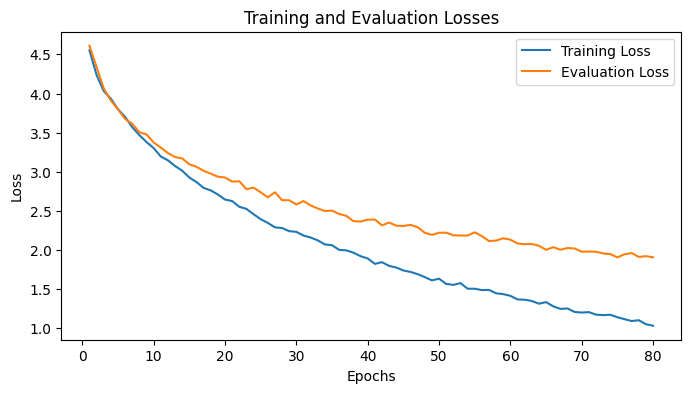

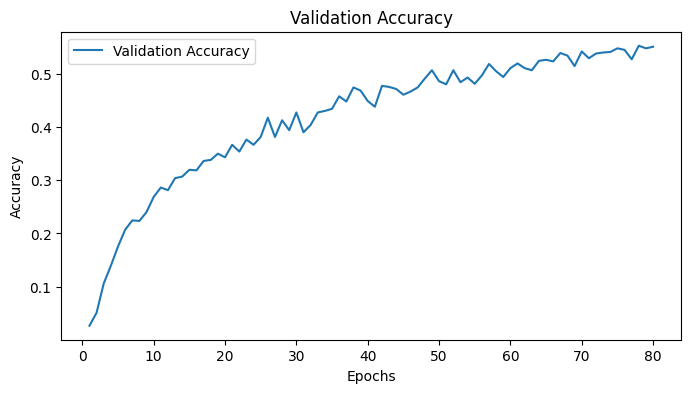

In [14]:
model = FlowerClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train(model, training_loader, evaluation_loader, criterion, optimizer, epochs=200)

In [15]:
torch.save(model.state_dict(), 'flowers-102.pth')

In [16]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 222, 222]             896
       BatchNorm2d-2         [-1, 32, 222, 222]              64
         MaxPool2d-3         [-1, 32, 111, 111]               0
           Dropout-4         [-1, 32, 111, 111]               0
            Conv2d-5         [-1, 64, 109, 109]          18,496
       BatchNorm2d-6         [-1, 64, 109, 109]             128
         MaxPool2d-7           [-1, 64, 54, 54]               0
           Dropout-8           [-1, 64, 54, 54]               0
            Conv2d-9          [-1, 128, 52, 52]          73,856
      BatchNorm2d-10          [-1, 128, 52, 52]             256
        MaxPool2d-11          [-1, 128, 26, 26]               0
          Dropout-12          [-1, 128, 26, 26]               0
           Conv2d-13          [-1, 256, 24, 24]         295,168
      BatchNorm2d-14          [-1, 256,

In [17]:
def evaluate(model, evaluation_loader, criterion):
    model.eval()
    evaluation_loss = 0.0
    correct = 0
    total = 0
    misclassified_images = []

    with torch.no_grad():
        for inputs, labels in evaluation_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            evaluation_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            misclassified_inds = (predicted != labels).nonzero()
            for mis_ind in misclassified_inds:
                mis_img = inputs[mis_ind].cpu()
                mis_label = labels[mis_ind].cpu()
                mis_pred = predicted[mis_ind].cpu()
                misclassified_images.append((mis_img, mis_label, mis_pred))

    evaluation_loss /= len(evaluation_loader.dataset)
    evaluation_accuracy = correct / total

    print(f'Evaluation Loss: {evaluation_loss:.4f}, Accuracy: {evaluation_accuracy:.4f}')

    return misclassified_images

misclassified_images = evaluate(model, evaluation_loader, criterion)
print(f'There were {len(misclassified_images)} images predicted incorrectly by the model.')

Evaluation Loss: 1.9068, Accuracy: 0.5510
There were 458 images predicted incorrectly by the model.


In [18]:
def list_misclassification_examples_per_class(misclassified_images, num_examples=1):
    classes_dict = {}
    total_misclassified = 0

    for _, true_label, pred_label in misclassified_images:
        true_label = true_label.item()
        pred_label = pred_label.item()
        if true_label not in classes_dict:
            classes_dict[true_label] = {"count": 0, "examples": []}
        if classes_dict[true_label]["count"] < num_examples:
            classes_dict[true_label]["examples"].append(pred_label)
        classes_dict[true_label]["count"] += 1
        total_misclassified += 1

    for true_label, misclassified_info in classes_dict.items():
        print(f"True Label: {true_label}, Misclassified Count: {misclassified_info['count']}")

    print(f"Total Misclassified Images: {total_misclassified}")

# Assuming num_classes is defined and represents the total number of classes
num_classes = 102  # Adjust this according to your dataset

# List misclassification examples per class
list_misclassification_examples_per_class(misclassified_images)

True Label: 0, Misclassified Count: 1
True Label: 1, Misclassified Count: 5
True Label: 2, Misclassified Count: 9
True Label: 3, Misclassified Count: 9
True Label: 4, Misclassified Count: 5
True Label: 5, Misclassified Count: 6
True Label: 6, Misclassified Count: 2
True Label: 8, Misclassified Count: 9
True Label: 10, Misclassified Count: 10
True Label: 11, Misclassified Count: 6
True Label: 12, Misclassified Count: 1
True Label: 13, Misclassified Count: 1
True Label: 14, Misclassified Count: 3
True Label: 15, Misclassified Count: 4
True Label: 20, Misclassified Count: 5
True Label: 16, Misclassified Count: 4
True Label: 17, Misclassified Count: 7
True Label: 18, Misclassified Count: 5
True Label: 19, Misclassified Count: 3
True Label: 21, Misclassified Count: 1
True Label: 22, Misclassified Count: 7
True Label: 23, Misclassified Count: 3
True Label: 24, Misclassified Count: 2
True Label: 25, Misclassified Count: 4
True Label: 26, Misclassified Count: 4
True Label: 27, Misclassified Co

Misclassified images from the training and evaluation sets:
Class 2


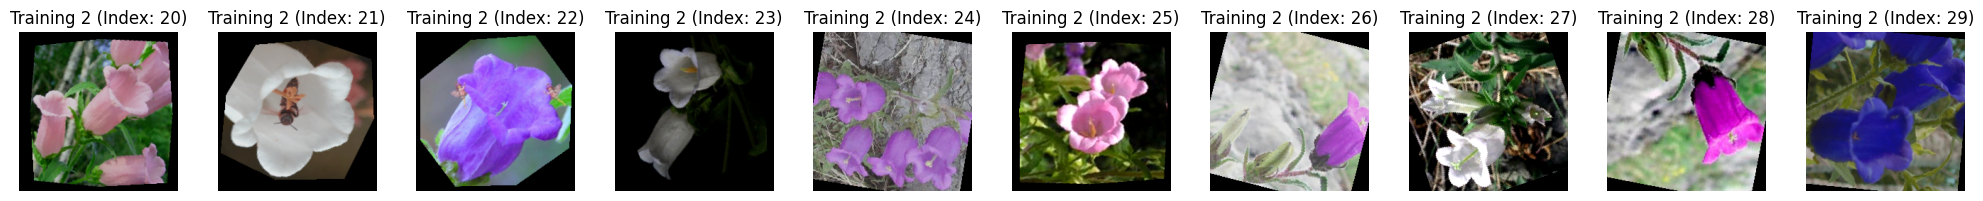

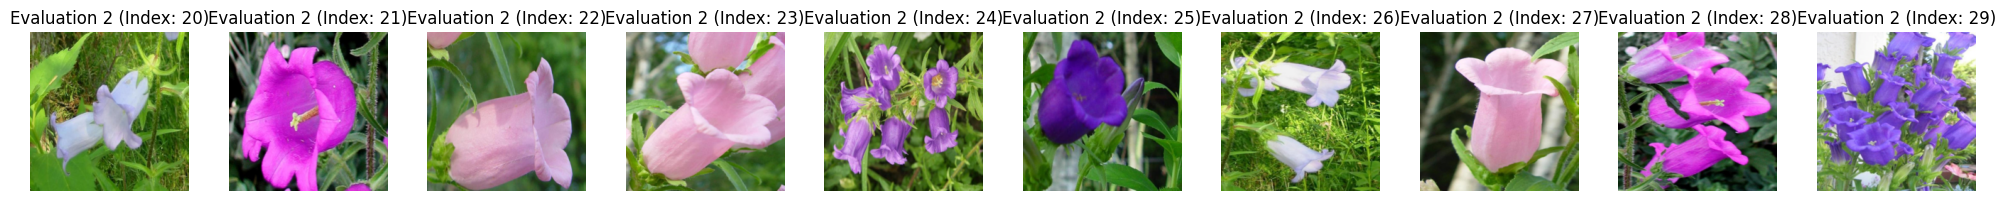

Class 79


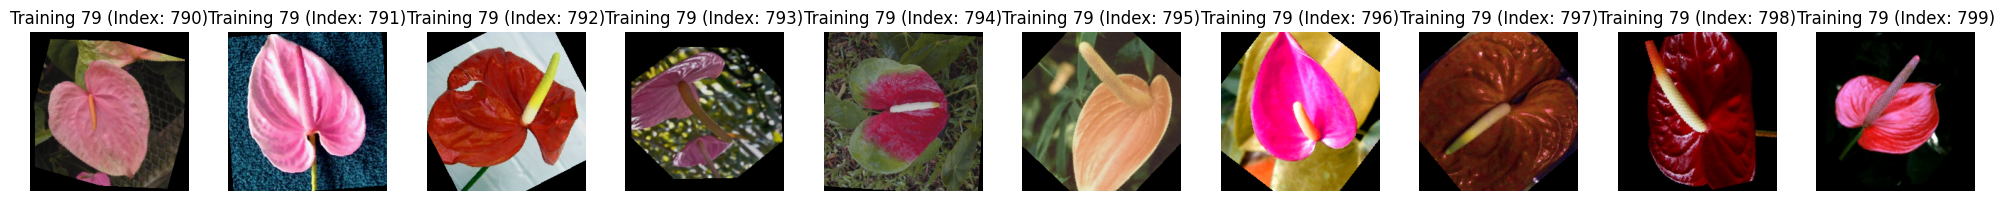

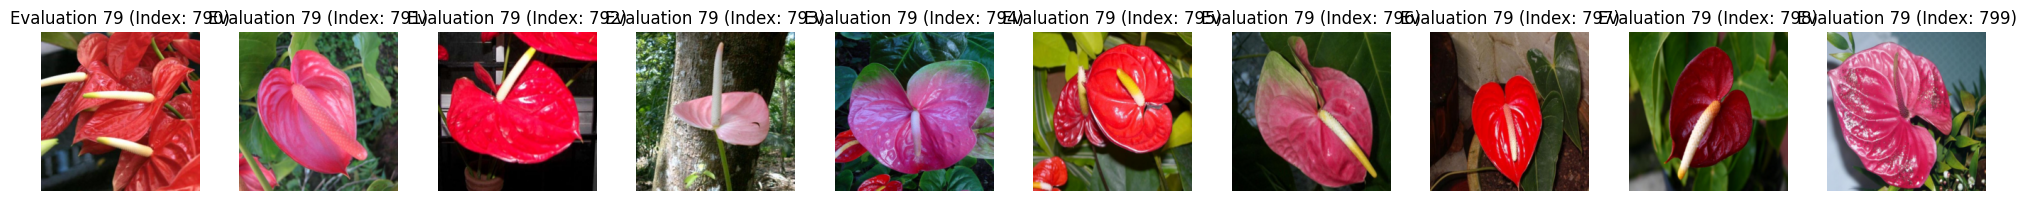

Class 89


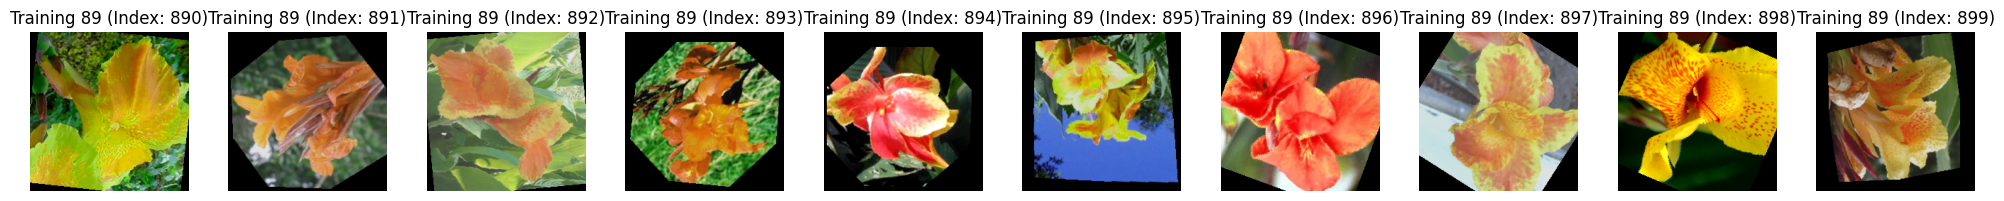

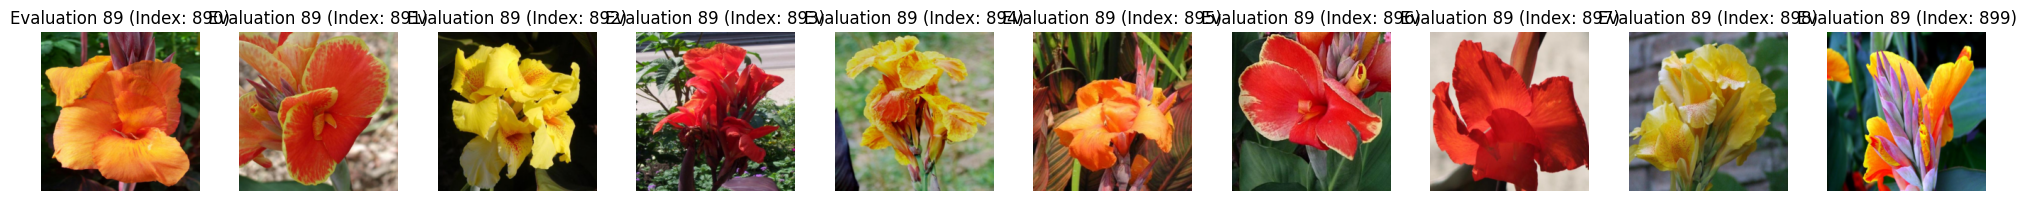

Class 93


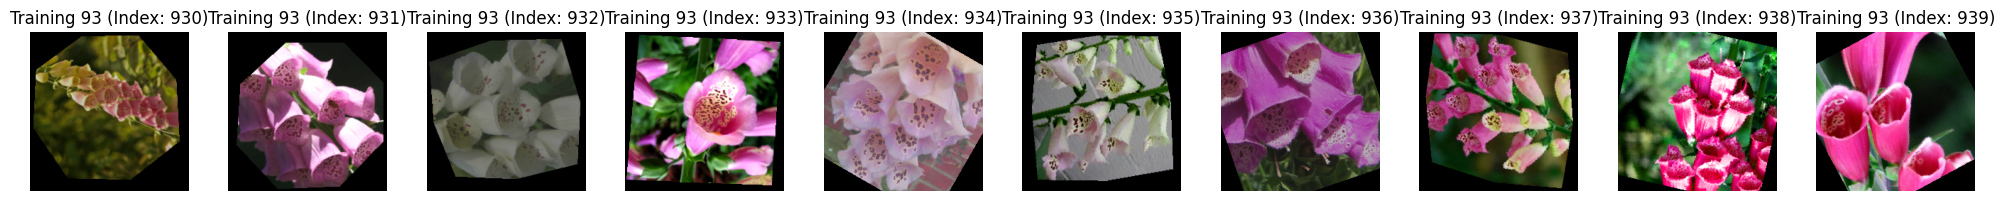

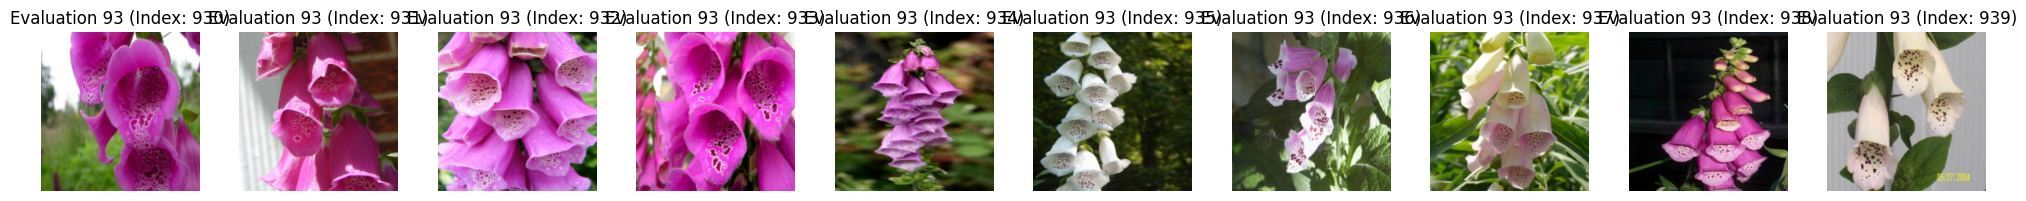

Class 42


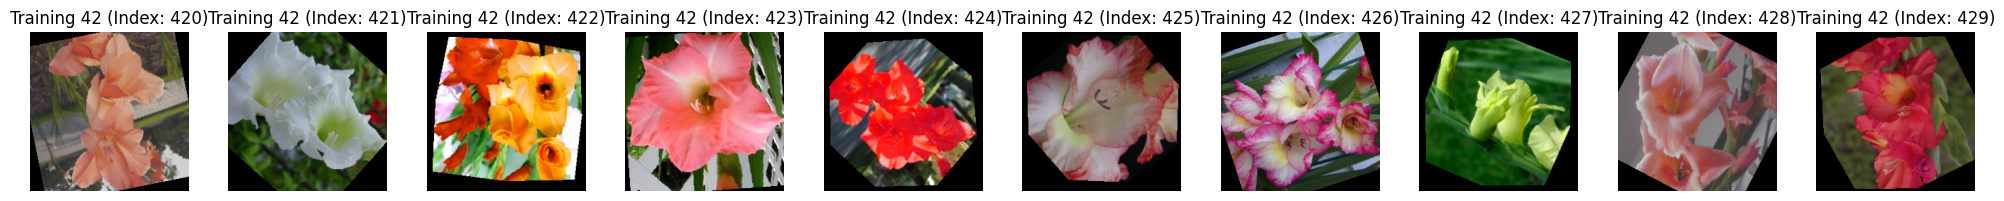

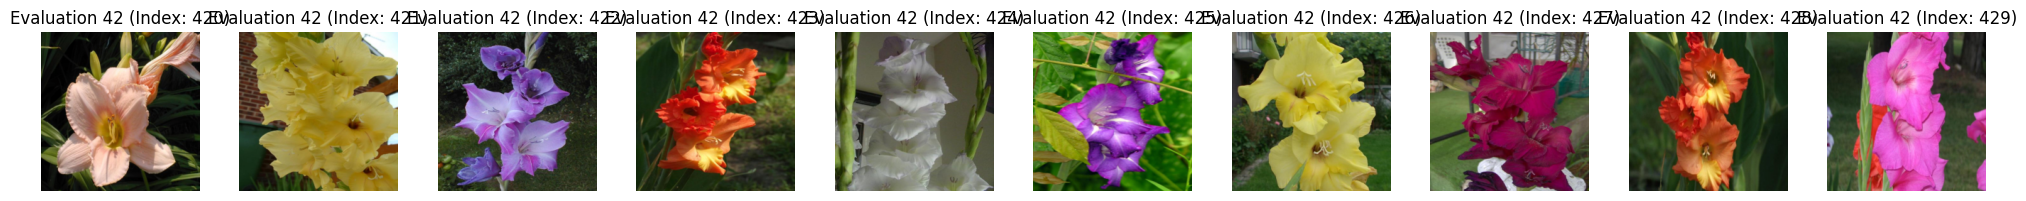

Class 52


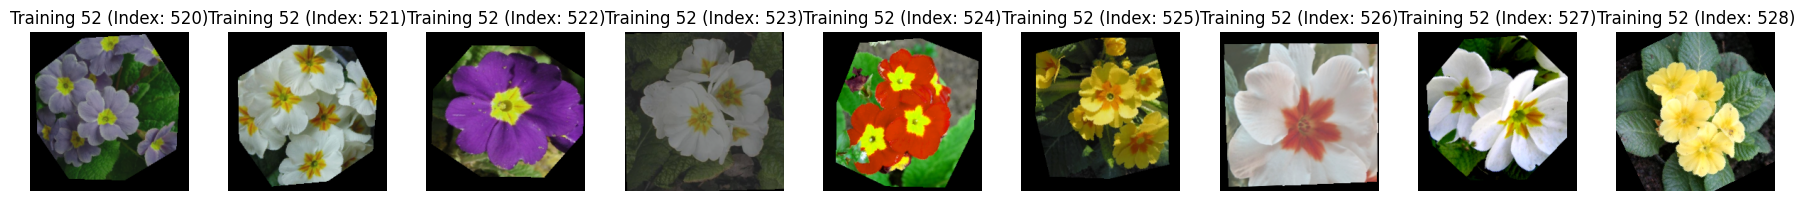

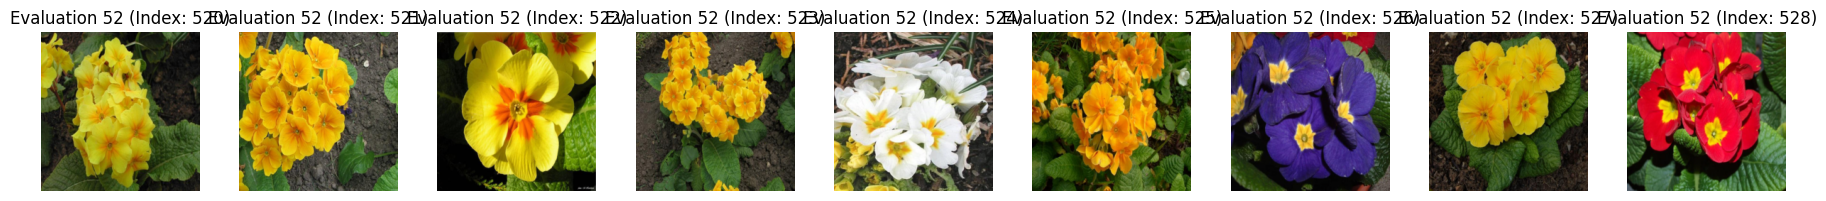

In [19]:
# Define a function to plot images
def plot_images(images, titles, rows, cols):
  fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
  for i, ax in enumerate(axes.flat):
      ax.imshow(images[i])
      ax.set_title(titles[i])
      ax.axis('off')
  plt.tight_layout()
  plt.show()

# Define the indices of misclassified flowers
# just have a list of each class that had more than 7 flowers misclassified and
# then print all images in class for both sets
misclassified_indices = {
2: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
79: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
89: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
93: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
42: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
52: [0, 1, 2, 3, 4, 5, 6, 7, 8],
}

# Define a function to plot misclassified images for each class
def plot_misclassified_images(train_dataset, eval_dataset, indices):
  for class_name, idx_list in indices.items():
    misclassified_images_train = []
    titles_train = []
    misclassified_images_eval = []
    titles_eval = []
    for idx in idx_list:
        true_idx = class_name * 10 + idx
        img_train, _ = train_dataset[true_idx]
        img_eval, _ = eval_dataset[true_idx]

        img_train = (img_train.squeeze().permute(1, 2, 0).numpy() * std + mean.clip(0, 1))
        img_eval = (img_eval.squeeze().permute(1, 2, 0).numpy() * std + mean.clip(0, 1))

        misclassified_images_train.append((img_train * 255).astype('uint8'))
        titles_train.append(f'Training {class_name} (Index: {true_idx})')
        misclassified_images_eval.append((img_eval * 255).astype('uint8'))
        titles_eval.append(f'Evaluation {class_name} (Index: {true_idx})')

    print(f'Class {class_name}')
    plot_images(misclassified_images_train, titles_train, 1, len(idx_list))
    plot_images(misclassified_images_eval, titles_eval, 1, len(idx_list))

print("Misclassified images from the training and evaluation sets:")
plot_misclassified_images(training_data, evaluation_data, misclassified_indices)